# STATS 604: Ripening Fruit
## Team Members: Alex Kagan, Daniele Bracale, Josh Wasserman, Xinhe Wang, and Yash Patel
We present herein the findings from our explorations on the ripening of bananas. In this report, we present some our experimental design along with the raw data processing pipeline, statistical analyses, and conclusions. The report is, therefore, broken into the following sections:

- Experimental Design
- Data processing
- Permutation test analyses
- Conclusion

Each section is annotated with the corresponding code and figures in the sections below along with associated exposition.

## Introduction

Fruits in general ripen through the conversion of starch to sugars. Ideally, we’d be able to measure this conversion process chemically, but we don’t have access to refractometers. We can define the "true" ripeness as being this ratio of sugars to starches. So, we use a number of proxies that correlate strongly with this ripeness.

Starch, a complex carbohydrate, is broken into simple sugars through a reaction with ethylene. However, this release of ethylene also results in a number of other reactions that are clearly visible. Specifically, ethylene additionally breaks down pectin, which is responsible for the structural integrity of the banana. This is why bananas also grow softer as they ripen. Similarly, the release of ethylene results in the breakdown of chlorophyll, which then gives rise to the characteristic yellow and eventual browning color of bananas. This is surprisingly the same process that happens with leaves, although not all the same pigments are present in banana skins, which is why there is only really a progression from yellow to brown.

So, we want to conceptually measure:

Ripeness measurements
- Color
- Firmness
- Sweetness

## Experimental measures
**Color**: The color of bananas characteristically changes in two ways in ripening: becoming more yellow and subsequently developing brown spots. We will, therefore, have two measures towards this end. For both, take a picture of the banana on a white piece of paper. Place a "registration" grey card (printed) to serve as a fixed normalization point for white balance in post-processing. In post-processing, after normalizing colors, segment the banana in the image. Run a connected components segmentation analysis to find the "brown spots" and compute the area as the number of pixels (as a proportion to the total area). For the remainder of the banana, compute the average RGB. (Idealized) green in RGB is (0, 255, 0), whereas (idealized) yellow is (255, 255, 0), so the average red channel should serve as a rough proxy for the ripeness (w.r.t. color). Part of the reason for this bifurcated analysis is to account for the fact brown does not have a greater red value than yellow, meaning there is an inflection in the red channel with respect to ripeness which would skew results that were the average run pre-segmentation.

**Firmness**: Unpeel the banana and cut off a 2" segment from the middle. Place the banana piece on a white piece of paper and then place a fixed weight atop it for a fixed period of time (20 seconds). We will take a picture before and after exposure to the weight and see the percentage change in the resulting number of pixels as a measure of how much the banana got "squished."

## Raw Data
Bananas were exposed to different "accompanying" fruits to observe their effects on the ripening process, with data collected in the following fashion:

1. Take a picture of each banana  as described in the "color" portion of the experimental measures section
2. Randomly place N/3 bananas in each of three boxes
3. Place nothing additional in one box, 3 apples in another, and 3 tomatoes in the last
4. Leave these boxes for 5 days, taking a picture each day as described in the "color" portion of the experimental measures section
5. Measure the above listed "experimental measures" on the final day

The raw data are available in the corresponding Day_* folder.

## RGB Analysis
In this section we process the data in the following way:

1. Collect all the bananas' pics for all the 5 day.

2. For each banana pic, make a selection, i.e. select the banana only and put it in a completely white background. This helps in having pixels not corresponding to a banana location be equal to $(255,255,255)$.

3. Read each banana pic from previous step in R and: count the number of non-white pixels, i.e. the pixels corresponding to the banana.

4. Transform the pic into "greyscale" in order to have a unique channel and being able to select the brown spots with a uniform measure. Count the number of pixels with values less than $0.5$ (recall that in R the maximum RGB value is $1$ instead of $255$) and divide this number by the number of non-white pixels in step 2. The result is the proportion of black spots in the banana. Then $1$ minus this proportion is the proportion of yellow (non-brown) spots. Take also the average of the red channel values corresponding to the non-brown spots.

5. Collect the data for the proportion of brown spots, yellow spots and the average of red spots for each banana and output a csv file. For each banana we also add a variable that specify the treatment: $C$ for control, $A$ for apple and $T$ for tomato.

In [5]:
library(imager)
library(dplyr)

data_black <- data.frame("banana" = seq_len(36),
                   "trt" = rep(c("C", "A", "T"), each = 12))
data_yellow <- data.frame("banana" = seq_len(36),
                   "trt" = rep(c("C", "A", "T"), each = 12))
data_avg_r <- data.frame("banana" = seq_len(36),
                         "trt" = rep(c("C", "A", "T"), each = 12))

for (j in 1:5) {
  proportion_black = c()
  proportion_yellow = c()
  avg_r = c()
  for (i in 1:36) {
    # Take the pictures from the folder containing the banana's pics
    banana = load.image(paste("../", "Day_", j, "/",i,".jpg",sep = ""))
    
    #plot(banana)
    #class(banana)
    #dim(banana)
    
    # Transform the bananapic in a data frame
    bdf_1 = as.data.frame(banana)
    
    # divide by 3 because there are 3 channels, each of them are repeated (RGB)
    total_area = dim(bdf_1)[1]/3
    white_area = dim(filter(bdf_1, value == 1))[1]/3
    banana_area = total_area - white_area
    
    # Transform the bananapic in a greyscale
    # sqrt because it helps dividing the black spots from the white.
    gbanana = sqrt(grayscale((banana)))
    #plot(gbanana)
    
    bdf_2 = as.data.frame(gbanana)
    # Select the most black spots
    black_spots = which(bdf_2$value<0.5)
    # Set to white all the other spots (only if you what to see the next plot
    #bdf_2[-black_spots,3]= 1
    
    black_area = length(black_spots)
    yellow_area = banana_area - length(black_spots)
    
    #as.cimg(bdf_2, dims = dim(gbanana)) %>% plot
    #aggregate(bdf, list(channel = bdf$cc),FUN = mean)
    
    proportion_black = c(proportion_black, black_area/banana_area)
    proportion_yellow = c(proportion_yellow, yellow_area/banana_area)
    
    # average of the R channel, excluding white area and black spots
    avg_r_channel <- mean(
      filter(bdf_1[bdf_1$cc == 1, ][bdf_2$value < 0.5, ], value < 1)$value)
    
    avg_r <- c(avg_r, avg_r_channel)
  }
  data_black <- cbind(data_black, proportion_black)
  data_yellow <- cbind(data_yellow, proportion_yellow)
  data_avg_r <- cbind(data_avg_r, avg_r)
}

colnames(data_black) <- c("banana", "trt", paste0("pct_brown_day_", seq(1, 5)))
colnames(data_yellow) <- c("banana", "trt", paste0("pct_yellow_day_", seq(1, 5)))
colnames(data_avg_r) <- c("banana", "trt", paste0("avg_rgb_day_", seq(1, 5)))


write.csv(data_black, "../processed_results/aggregated_measurements_black.csv", row.names = FALSE)
write.csv(data_yellow, "../processed_results/aggregated_measurements_yellow.csv", row.names = FALSE)
write.csv(data_avg_r, "../processed_results/aggregated_measurements_rgb.csv", row.names = FALSE)

## Squish Analysis
To perform the analysis, there are two stages of the processing:
- Segment bananas out from the remainder of the image
- Count the masked pixel area of this segmented section

We perform the first by running an edge detector algorithm followed by a watershed algorithm to extract out the complete mask of the object. Note that there are some nuances about how this edge detection is implemented: a vanilla Canny edge detector fails to work because of small issues with leaving "gaps" in the object boundary. 

The final "squish ratio" is defined as:

$$ \frac{\%pixels_{after}}{\%pixels_{before}} $$

In [1]:
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [2]:
def get_mask(hed, seed_point=(300, 250)):
    t = 0
    mask = hed.copy()
    mask[mask == t] = 0
    mask[mask > t] = 255

    mask[:, :200] = 0
    mask[:, 400:] = 0
    mask[:200, :] = 0
    mask[350:, :] = 0
    
    kernel = np.ones((5, 5), np.uint8)
    img_dilation = cv2.dilate(mask, kernel, iterations=10)
    mask = cv2.erode(img_dilation, kernel, iterations=10)

    cv2.floodFill(mask, None, seedPoint=seed_point, newVal=255)
    return mask

In [3]:
import urllib.request
import matplotlib.pyplot as plt

url = "https://github.com/ashukid/hed-edge-detector/raw/master/hed_pretrained_bsds.caffemodel"
urllib.request.urlretrieve(url, "hed_pretrained_bsds.caffemodel")

('hed_pretrained_bsds.caffemodel', <http.client.HTTPMessage at 0x7fa9f190d0a0>)

In [ ]:
special_seeds = {
    "before": {
        2: (300, 300),
        3: (225, 275),
        4: (300, 300),
        5: (225, 275),
        7: (325, 275),
        8: (300, 300),
        9: (225, 275),
        10: (225, 275),
        11: (300, 300),
        15: (225, 225),
        20: (300, 300),
        29: (300, 300),
        36: (225, 275),
    },
    "after": {
        3: (300, 300),
        5: (225, 275),
        7: (350, 275),
        8: (275, 275),
        9: (225, 275),
        10: (225, 275),
        17: (325, 300),
        20: (300, 300),
        28: (300, 300),
        29: (300, 300),
    },
}

for folder in ["before", "after"]:
    for banana_idx in range(1, 37):
        root_folder = f"../SquishTest_Data"
        banana_fn = f"banana_{banana_idx}.jpeg"
        img_path = os.path.join(root_folder, folder, banana_fn)
        print(img_path)
        raw = cv2.imread(img_path)

        img = cv2.resize(raw, None, fx=0.15, fy=0.15)
        img = cv2.blur(img, (5,5)) 

        W, H, _ = img.shape
        blob = cv2.dnn.blobFromImage(img, scalefactor=1.0, size=(W, H), swapRB=False, crop=False)
        net = cv2.dnn.readNetFromCaffe("../deploy.prototxt", "hed_pretrained_bsds.caffemodel")

        net.setInput(blob)
        hed = net.forward()

        hed = cv2.resize(hed[0, 0], (W, H))
        hed = (255 * hed).astype("uint8")
        if banana_idx in special_seeds[folder]:
            seed_point = special_seeds[folder][banana_idx]
        else:
            seed_point = (300, 250)
        mask = get_mask(hed, seed_point=seed_point)

        dest = os.path.join(root_folder, "masked", folder, banana_fn)
        print(f"Writing to: {dest}")
        cv2.imwrite(dest, mask)

In [6]:
squishes = []
for banana_idx in range(1, 37):
    root_folder = f"../SquishTest_Data"
    banana_fn = f"banana_{banana_idx}.jpeg"
    before_mask = cv2.imread(os.path.join(root_folder, "masked", "before", banana_fn), 0) > 0
    after_mask = cv2.imread(os.path.join(root_folder, "masked", "after", banana_fn), 0) > 0

    before_area = np.sum(before_mask)
    after_area = np.sum(after_mask)

    squish = after_area / before_area
    squishes.append(squish)
squishes = np.array(squishes)

index = [f"banana_{banana_idx}" for banana_idx in range(1, 37)]
df = pd.DataFrame(squishes, columns=["squish"], index=index)
df.to_csv("squish.csv")

## Permutation Test
Justified by the random allocation of bananas, we performed permutation tests for each of our treatment conditions. 

First, we tested if tomatoes accelerate the ripening process of bananas with the following competing hypotheses:
$$ H_0:\ \text{Tomatoes do not accelerate the ripening process of bananas} $$
verses
$$ H_a:\ \text{Tomatoes accelerate the ripening process of bananas.} $$

For this test, we only used the data of tomato and control groups, randomly permuted the treatment labels for 20,000 times, and used the difference-in-means of tomato verses control as our test statistic. More specifically, we computed the contrast between the mean outcomes under each treatment label for each permutation. Then we compare the observed difference-in-means with the permuted distribution and find out if our observations are unusual under the null hypothesis.

In [2]:
set.seed(30001)

#setwd(dirname(rstudioapi::getActiveDocumentContext()$path))

outcome_brown <- read.csv("../processed_results/aggregated_measurements_black.csv")
outcome_rgb <- read.csv("../processed_results/aggregated_measurements_rgb.csv")
outcome_squish <- read.csv("../processed_results/squish.csv")

obs <- data.frame(
  trt = rep(c("C", "A", "T"), each = 12),
  avg_rgb = outcome_rgb$avg_rgb_day_5 - outcome_rgb$avg_rgb_day_1,
  pct_brown = outcome_brown$pct_brown_day_5 - outcome_brown$pct_brown_day_1,
  pct_squished = outcome_squish$squish
)

obs_t <- obs[c(1:12, 25:36), ]
obs_a <- obs[1:24, ]

n_ctrl_bananas <- n_tomato_bananas <- n_apple_bananas <- 12
n_bananas <- sum(c(n_ctrl_bananas, n_tomato_bananas, n_apple_bananas))
# obs <- data.frame(
#  "banana" = seq_len(n_bananas),
#  "trt" = rep(c("C", "A", "T"), each = n_bananas / 3),
#  "avg_rgb" = rnorm(n_bananas),
#  "pct_brown" = runif(n_bananas),
#  "pct_squished" = runif(n_bananas)
#)
outcome_colnames <- c("avg_rgb", "pct_brown", "pct_squished")

n_permutations <- choose(n_bananas, n_ctrl_bananas) * 
  choose(n_bananas - n_ctrl_bananas, n_apple_bananas)
n_test_permutations <- 20000

test_data <- data.frame(
  "permutation" = seq_len(n_test_permutations),
  "avg_rgb_tomato" = rnorm(n_test_permutations),
  "avg_rgb_apple" = rnorm(n_test_permutations),
  "pct_brown_tomato" = rbeta(n_test_permutations, 1, 1),
  "pct_brown_apple" = rbeta(n_test_permutations, 1, 1),
  "pct_squished_tomato" = rbeta(n_test_permutations, 1, 1),
  "pct_squished_apple" = rbeta(n_test_permutations, 1, 1)
)

# Josh's code of generating permutations
assignments <- c(
  rep("C", n_ctrl_bananas), 
  rep("T", n_tomato_bananas)
)
permutations_t <- data.frame(
  t(mapply(function(x) sample(assignments), seq_len(n_test_permutations))),
  row.names = NULL
)
colnames(permutations_t) <- paste0(
  "banana_", c(seq(n_ctrl_bananas), 
               seq(n_ctrl_bananas + n_apple_bananas + 1, n_bananas))) 

assignments <- c(
  rep("C", n_ctrl_bananas), 
  rep("A", n_apple_bananas)
)
permutations_a <- data.frame(
  t(mapply(function(x) sample(assignments), seq_len(n_test_permutations))),
  row.names = NULL
)
colnames(permutations_a) <- paste0("banana_", seq_len(n_ctrl_bananas + n_apple_bananas)) 


# find the test statistic (difference-in-means) for all test permutations
for (i in 1:n_test_permutations){
  # compute the difference-in-means
  test_stats_t <- 
    colMeans(obs_t[permutations_t[i, ]=="T", outcome_colnames]) - 
    colMeans(obs_t[permutations_t[i, ]=="C", outcome_colnames])
  test_stats_a <- 
    colMeans(obs_a[permutations_a[i, ]=="A", outcome_colnames]) - 
    colMeans(obs_a[permutations_a[i, ]=="C", outcome_colnames])
  
  test_data[i, "avg_rgb_tomato"] <- test_stats_t["avg_rgb"]
  test_data[i, "pct_brown_tomato"] <- test_stats_t["pct_brown"]
  test_data[i, "pct_squished_tomato"] <- test_stats_t["pct_squished"]
  
  test_data[i, "avg_rgb_apple"] <- test_stats_a["avg_rgb"]
  test_data[i, "pct_brown_apple"] <- test_stats_a["pct_brown"]
  test_data[i, "pct_squished_apple"] <- test_stats_a["pct_squished"]
}

# these lines can be kept, but replace test_data with xinhe's final dataframe
data_to_write1 <- cbind(test_data[,c(1,2,4,6)], permutations_t)
#head(data_to_write1)
write.csv(data_to_write1, "../permutations_tomato.csv", row.names = FALSE)

data_to_write2 <- cbind(test_data[,c(1,3,5,7)], permutations_a)
#head(data_to_write2)
write.csv(data_to_write2, "../permutations_apple.csv", row.names = FALSE)


# p-values
# first compute the difference-in-means
dim_stats_t <- 
  colMeans(obs[obs$trt=="T", outcome_colnames]) - 
  colMeans(obs[obs$trt=="C", outcome_colnames])
dim_stats_a <- 
  colMeans(obs[obs$trt=="A", outcome_colnames]) - 
  colMeans(obs[obs$trt=="C", outcome_colnames])

# then compute the p-values
p1 <- sum(dim_stats_t["avg_rgb"] <= test_data$avg_rgb_tomato) / n_test_permutations
p2 <- sum(dim_stats_a["avg_rgb"] <= test_data$avg_rgb_apple) / n_test_permutations

p3 <- sum(dim_stats_t["pct_brown"] <= test_data$pct_brown_tomato) / n_test_permutations
p4 <- sum(dim_stats_a["pct_brown"] <= test_data$pct_brown_apple) / n_test_permutations

p5 <- sum(dim_stats_t["pct_squished"] <= test_data$pct_squished_tomato) / n_test_permutations
p6 <- sum(dim_stats_a["pct_squished"] <= test_data$pct_squished_apple) / n_test_permutations

p.values <- data.frame("Average R" = c(p1, p2),
                       "Brown Percentage" = c(p3, p4),
                       "Squish Ratro" = c(p5, p6))
rownames(p.values) <- c("tomato", "apple")
#write.csv(p.values, "p-values.csv")

The following plot visualizes the number of times of every banana being labeled control or tomato among the 20,000 permutations. It shows that for each banana, in around half of the permutations they were labeled control and in the other half they were labeled tomato. Thus, the permutation test is solid with respect to the random allocation of treatment labels.

![](../plots/plot3a.png){width=50%}


The story is similar with testing the effect of apples. The competing hypotheses we are interested in are
$$ H_0:\ \text{Apples do not accelerate the ripening process of bananas} $$
verses
$$ H_a:\ \text{Apples accelerate the ripening process of bananas.} $$

We only used the data of apple and control groups. We permuted the treatment labels for 20,000 times and for each permutation, computed the difference-in-means of apple verses control as the test-statistic. The following plot shows that our permutation test has done a good job of randomly assigning the labels and thus is solid. 

![](../plots/plot3b.png){width=50%}

The computed $p$-values are shown in the following table, which we will explain in more detail in the next section.

In [3]:
library(knitr)
kable(p.values)



|       | Average.R| Brown.Percentage| Squish.Ratro|
|:------|---------:|----------------:|------------:|
|tomato |   0.80945|          0.38175|       0.2371|
|apple  |   0.98025|          0.90625|       0.2655|

In [6]:
library(grDevices)
library(dplyr)
library(tidyr)
library(ggplot2)
setwd("../")
permutations <- read.csv("permutations.csv", row.names = NULL)
permutations_tomato <- read.csv("permutations_tomato.csv", row.names = NULL)
permutations_apple <- read.csv("permutations_apple.csv", row.names = NULL)
data_black <- read.csv("processed_results/aggregated_measurements_black.csv", row.names = NULL)
data_yellow <- read.csv("processed_results/aggregated_measurements_yellow.csv", row.names = NULL)
data_avg_r <- read.csv("processed_results/aggregated_measurements_rgb.csv", row.names = NULL)
squish <- read.csv("processed_results/squish.csv", row.names = NULL)
squish$banana <- gsub("banana_", "", squish$X)
squish$pct_squished <- squish$squish
measurements <- merge(data_avg_r,
                      merge(data_black, data_yellow, by = c("banana", "trt")),
                      by = c("banana", "trt"))
measurements <- merge(measurements, squish[, c("banana", "pct_squished")])
measurements$avg_rgb <- measurements$avg_rgb_day_5 - measurements$avg_rgb_day_1
measurements$pct_brown <- measurements$pct_brown_day_5 - measurements$pct_brown_day_1

GREEN <- "#12b30c"
BROWN <- "#4a4d09"
YELLOW <- "#f2db2c"
PVAL_BLUE <- "#0726f0"
n_bananas <- 36
title_size <- 16
text_size <- 14
plot_theme <- theme(panel.background = element_blank(),
                    axis.text = element_text(size = text_size),
                    axis.title = element_text(size = title_size),
                    legend.text = element_text(size = text_size),
                    legend.title = element_text(size = title_size),
                    strip.text = element_text(size = text_size))

stat_cols <- colnames(permutations)[!grepl("(banana|permutation)", colnames(permutations))]
true_test_statistics <- mapply(
  function(stat) {
    if (grepl("apple$", stat)) {
      trt <- "A"
      stat <- gsub("_apple", "", stat)
    } else if (grepl("tomato$", stat)) {
      trt <- "T"
      stat <- gsub("_tomato", "", stat)
    } else {
      stop("Did not encounter a valid treatment level")
    }
    mean(measurements[measurements$trt == trt, stat]) - mean(measurements[measurements$trt == "C", stat])
  },
  stat_cols,
  USE.NAMES = TRUE
)

### Results
No permutation test yielded a significant p-value. The two smallest p-values
came from the tests for the squish ratio test statistic: the permutation test of
the bananas in the control environment and the bananas stored with apples returned a
p-value of 0.24, and the permutation test of the control bananas and the bananas
stored with tomatoes returned a p-value of 0.27. Using the percentage of brown
spots test statistic, the test of the tomato treatment yielded a p-value of .382,
and the test of the apple treatment yielded an even larger p-value of .906. The tests
using average red channel test statistic produced the highest p-value on average
across the tests of the two treatments: the test of the tomato treatment yielded
a p-value of 0.81, and the test of the apple treatment yielded a p-value of 0.98.

Despite the overwhelmingly large p-values, visualizations of the permutation
distributions for the average red channel tests may reveal useful information about
the experimental design. The histograms below showing the
results from these permutation tests display the distribution of test statistics from
all permutations in brown, then in different shades of yellow and green,
the distribution of test statistics from permutations where each banana was
labeled as a treatment banana. For the test of the tomato treatment, each of these
"banana-specific" permutation distributions looks to have the same general shape as
the overall permutation distribution. For the test of the apple treatment, however,
there appears to be one "banana-specific" distribution whose shape differs somewhat
notably from the distribution of all the permutations, which is made clearer in
the histogram below.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


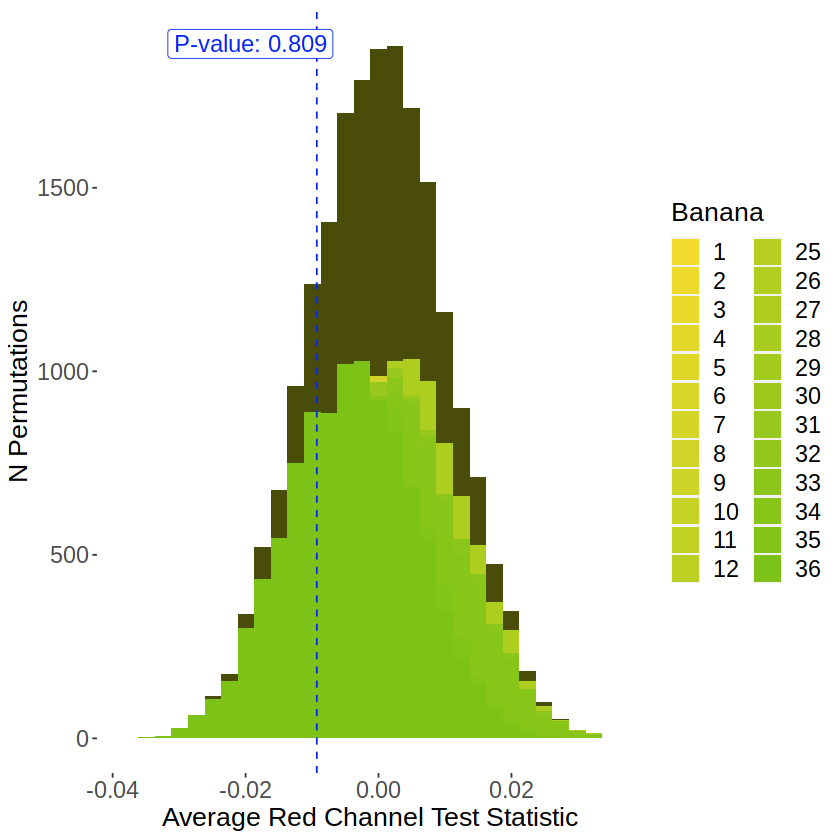

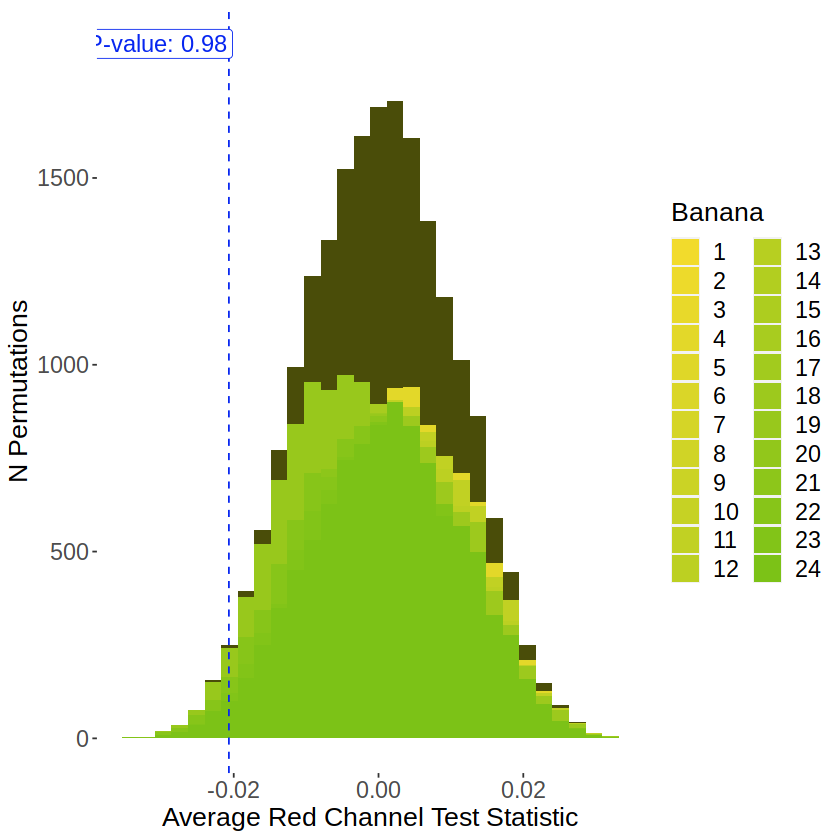

In [7]:
make_all_bananas_comparison_plot <- function(perms, stat) {
  if (grepl("tomato$", stat)) {
    trt <- "T"
    clean_trt <- "Tomato"
  } else if (grepl("apple$", stat)) {
    trt <- "A"
    clean_trt <- "Apple"
  } else {
    trt <- "C"
    clean_trt <- "Control"
  }
  clean_stat <- gsub(
    "% squished", "Squish Ratio",
      gsub(
        "pct", "%", gsub(
          "avg", "Average", gsub(
            "rgb", "Red Channel", gsub(" (tomato|apple)$", "", gsub("_", " ", stat))))))
  
  banana_cols <- colnames(perms)[grepl("banana", colnames(perms))]
  pivot_data <- Reduce(
    rbind,
    lapply(banana_cols, 
          function(banana_col) {
            msk <- perms[banana_col] == trt
            banana_perms <- perms[msk,
                                  c(banana_col, colnames(perms)
                                    [!grepl("banana", colnames(perms))])]
            colnames(banana_perms)[1] <- "trt"
            cbind("Banana" = as.numeric(gsub("banana_", "", banana_col)),
                  banana_perms)
          })
  )
  pivot_data$Banana <- factor(pivot_data$Banana,
                              levels = as.numeric(gsub("banana_", "", banana_cols)))

  # running one-sided tests because trt should increase avg RGB and pct brown
  pval <- mean(perms[[stat]] >= true_test_statistics[stat])
  if (grepl("pct_brown", stat)) {
    pval_label_x_val <- true_test_statistics[stat] + sign(true_test_statistics[stat]) * 0.002
    cut_val <- 0.00025
  } else if (grepl("avg_rgb", stat)) {
    pval_label_x_val <- true_test_statistics[stat] + sign(true_test_statistics[stat]) * 0.01
    cut_val <- 0.0025
  } else {
    pval_label_x_val <- true_test_statistics[stat] + sign(true_test_statistics[stat]) * 0.1
    cut_val <- 0.025
  }
  
  pval_label_y_val <- max(table(cut_width(perms[[stat]], width = cut_val)))
  ggplot(perms) +
    geom_histogram(aes(x = !!sym(stat)), fill = BROWN) +
    geom_histogram(data = pivot_data,
                   aes(x = !!sym(stat), fill = Banana),
                   position = "identity") +
    geom_vline(aes(xintercept=true_test_statistics[stat]), color = PVAL_BLUE,
               linetype="dashed") +
    scale_fill_manual(
      values = scales::seq_gradient_pal(YELLOW, GREEN)(seq(0, 1, length.out=n_bananas))) +
    labs(x = paste0(clean_stat," Test Statistic"),
         y = "N Permutations") +
    annotate("label", x = pval_label_x_val, y = pval_label_y_val,
             label = paste0("P-value: ", round(pval, 3)),
             color = PVAL_BLUE, size = 5) +
    plot_theme
}
for (r in seq_len(2)) {
  stat_col <- stat_cols[r]
  if (grepl("apple", stat_col)) {
    print(make_all_bananas_comparison_plot(permutations_apple, stat_col))
  } else if (grepl("tomato", stat_col)) {
    print(make_all_bananas_comparison_plot(permutations_tomato, stat_col))
  } else {
    stop("Did not encounter a valid stat col")
  }
}

This banana had a change in average red channel between days 1 and 5 of -0.02,
by far the lowest of all the bananas and theoretically impossible under the
monotonicity assumption underlying our decision to use average red channel as a
test statistic. This forces us to look more closely at few things, the first being
whether our method of calculating average red channel needs to be improved. Do
we need to adjust our method of calibrating the amount of light in each photo? Should
we normalize the red channel of each pixel in a photo before taking the average of
the pixels displaying the banana? Would these be possible, they should reduce the
possibility of returning a negative value for this measurement. Even if the
possibility of returning a negative value were completely removed though, this result
also makes us consider whether a difference-in-means test statistic is appropriate
for this measurement. Based on the measurements obtained in this experiment, a few
bananas lagged behind noticeably in change in average red channel, which could be
due to measurement error, or they might have been outliers. Were their lag not
to be due to measurement error, it may be more appropriate to use an
outlier-robust test statistic such as the difference-in-medians in future tests
of the average red channel measurement.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


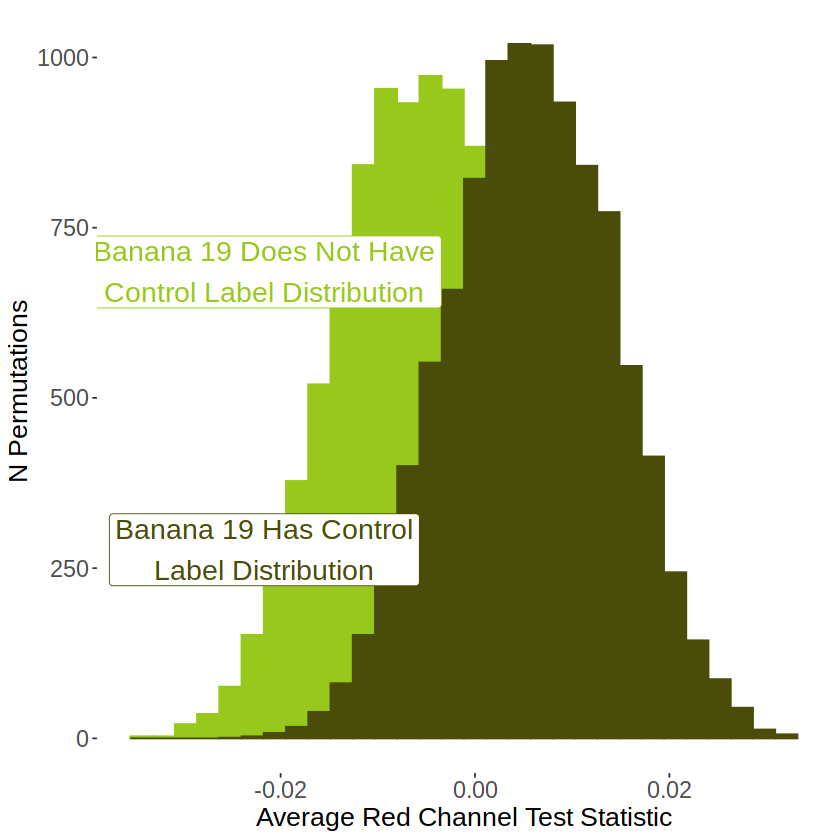

In [8]:
make_banana_specific_comparison_plot <- function(perms, banana, stat) {
  banana_col <- paste0("banana_", banana)
  if (grepl("tomato$", stat)) {
    trt <- "T"
    clean_trt <- "Tomato"
  } else if (grepl("apple$", stat)) {
    trt <- "A"
    clean_trt <- "Apple"
  } else {
    trt <- "C"
    clean_trt <- "Control"
  }
  clean_stat <- gsub(
    "% squished", "Squish Ratio",
       gsub(
         "pct", "%", gsub(
           "avg", "Average", gsub(
             "rgb", "Red Channel", gsub(" (tomato|apple)$", "", gsub("_", " ", stat))))))

  ctrl_data <- data.frame(
    "trt" = perms[[banana_col]][perms[banana_col] == "C"],
    "perm_val" = perms[[stat]][perms[banana_col] == "C"]
  )
  trt_data <- data.frame(
    "trt" = perms[[banana_col]][perms[banana_col] == trt],
    "perm_val" = perms[[stat]][perms[banana_col] == trt]
  )
  legend_x_val <- min(quantile(ctrl_data[["perm_val"]], 0.03),
                      quantile(trt_data[["perm_val"]], 0.03))
  if (grepl("pct_brown", stat)) {
    cut_val <- 0.00025
  } else if (grepl("avg_rgb", stat)) {
    cut_val <- 0.0015
  } else {
    cut_val <- 0.025
  }
  
  legend_y_val_banana <- max(table(cut_width(ctrl_data[["perm_val"]], width = cut_val)))
  legend_y_val_all <- max(table(cut_width(trt_data[["perm_val"]], width = cut_val))) - 400
  fill_col <- scales::seq_gradient_pal(YELLOW, GREEN)(seq(0, 1, length.out=n_bananas))[banana]
  
  ggplot(ctrl_data) +
    geom_histogram(data = trt_data,
                   aes(x = perm_val), fill = fill_col, color = fill_col) +
    geom_histogram(aes(x = perm_val), fill = BROWN, color = BROWN) +
    annotate("label", x = legend_x_val, y = legend_y_val_banana,
             label = paste0("Banana ", banana, " Does Not Have\nControl Label Distribution"),
             color = fill_col, size = 6) +
    annotate("label", x = legend_x_val, y = legend_y_val_all,
             label = paste0("Banana ", banana, " Has Control\nLabel Distribution"),
             color = BROWN, size = 6) +
    labs(x = paste0(clean_stat," Test Statistic"),
         y = "N Permutations") +
    plot_theme
}

make_banana_specific_comparison_plot(permutations_apple, 19, "avg_rgb_apple")

## Conclusions

### Limitations of the experiment design
Our statistical analysis was conducted under several important assumptions about the experiment design, however most of them were likely violated to some extend. Here, we present only the most important of these assumptions together with the reasons why they could be violated.

- Stable Unit Treatment Value Assumption (SUTVA): bananas in the same bag can influence ripening of each other 
- Equal treatment given to the bananas in each bag: apples / tomatoes could be lying closer to some bananas than to others in the bag and thus have a stronger effect on them
 - RGB measurements were not effected by camera angle/ shadow amount/ light intensity: since most of the experiment was done manually, we do not have guarantees that these characteristics maintained constant throughout the whole 5-day period.
- Bananas received equal pressure during squishing: since squishing was done by a person, it is almost impossible to make the pressure uniform.
- No side effects on ripeness when the bananas are taken out of the bag for RGB record: though likely negligible, there can be a possibly varying side effect from the surrounding during the record procedure.

### Further work

In future, we want to try measuring ripeness of a banana by its reaction to iodine, as stated in our pre-analysis. Though it can significantly increase the needed experiment budget, reaction to iodine can be a more robust statistic because the the color change of a banana under iodine addition is much more apparent than the natural change which we try to capture with a camera.

Among the possible improvements for our current experiment pipeline, we suggest:

- Moving the experiment to a room without any sources of natural light (basement, for example) to eliminate the light noise in RGB measurements
- Putting each banana with the treatment fruit/ vegetable in a separate bag to eliminate the effects of bananas on each other and eliminate the key source of possible SUTVA violations. 